## Instructions

- Amend model parameters section to desired parameters
- Then save this file as a dot py file and execute from terminal 




In [ ]:
from chemlibs import *
from molgraph import *
from utils import *

In [2]:
# Random seed 
seed=5678


# Setting random seeds
# random.seed(seed)
# np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

def seed_worker(worker_id):
    worker_seed = torch.initial_seed()%2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)


# Check that GPU is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

NVIDIA RTX A2000 12GB
cuda


### Model parameters

In [3]:
##################################################
########## Begin: Changeable parameters ##########
##################################################

# Model training parameters
modname = "gnn"
compression_mode = "mu1nu1"
learning_rate = 0.001
n_epochs = 300
patience = 50
batch_size = 32


# Hyperparameters sampling setup
sample_size = 20
species = [1, 5, 6, 7, 8, 9, 15, 16, 17, 35, 53]

bounds_norm = torch.tensor([[0,0,0,0,0],[1,1,1,1,1]],dtype=torch.float)
bounds_unnorm = [(3, 10), (3, 8), (3, 13), (0.1, 1.5), (3, 11)]


# Set path for where data is located 
datapath = "../data/"


# Set path for where simulation files are located, this generally is just blank, i.e., ""
path = ""


# File name that contains targets, SMILES, structure names
file=datapath+"lowe.csv"


# RDKit descriptors to use
# Add or delete based on RDKit descriptor names
desc_names=['MolWt', 'MolMR', 'HeavyAtomCount',
            'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
            'NumRotatableBonds', 'NumValenceElectrons',
            'NumAromaticRings', 'NumSaturatedRings',
            'NumAliphaticRings', 'RingCount', 'TPSA',
            'LabuteASA', 'BalabanJ', 'BertzCT', 'MolLogP']


# Select feature types for use in graphs and molecules
# Delete from the list to exclude from the graph
# keywords: "categorical","continuous","soap","rdkit"
node_feature_set = ["soap"]
edge_feature_set = ["categorical","continuous"]
molecule_feature_set = ["rdkit"]


# Set number of units in trainable layers of GNN
# Linear layer units that receive input (in index 0) will be updated 
# below regardless of what is set here
node_units = [0, 64]
edge_units = [0, 48, 32]
molecule_units = [17] 


# Number of units in final fully-connected neural network that outputs prediction
fcnn_units = [256, 128, 32]


################################################
########## End: Changeable parameters ##########
################################################

### Load data

In [4]:
# Load data
data=pd.read_csv(file)
names=data["Name"].values
y=data["logS"].values.reshape(-1,1)
SMILES=data["SMILES"].values

n_train=data.loc[data['set'] == "train"].shape[0]
n_test=data.loc[data['set'] == "test"].shape[0]
print("Training size: {},".format(n_train), "Test size: {}".format(n_test))

y_train=y[:n_train]
y_test=y[n_train:]

feature_sets={"node":node_feature_set,
              "edge":edge_feature_set,
              "molecule":molecule_feature_set}

# Load saved xyz coordinates in pkl file or load manually if save file not present
try:
    with open(datapath+'xyzs.pkl','rb') as handle:
        xyzs = pkl.load(handle)
except:
    xyzs={}
    for name in names:
        xyz = ase.io.read(datapath+"xyz/{}.xyz".format(name))
        xyzs[name] = xyz

Training size: 7655, Test size: 2552


In [5]:
# Create molecular graphs, done once and updated during each iteration for SOAPs
start=time()
MoleculeGraphs=[MoleculeGraph(names[i],
                              SMILES[i],
                              y[i],
                              i,
                              desc_names=desc_names,
                              feature_sets=feature_sets,
                              structure_format="xyz",
                              soap_parameters={"r_cut": 3.0, 
                                              "l_max": 1,
                                              "n_max": 1,
                                              "atom_sigma": 0.1,
                                              "compression_mode": compression_mode, 
                                              "species": species,}) for i in range(data.shape[0])]
end=time()
print("Molecular graph generation time: {:.3f} mins".format((end-start)/60))

Molecular graph generation time: 1.305 mins


### Prior distribution

In [ ]:
#####################################
##### Create prior distribution #####
#####################################

total_time = 0

# Obtaining Stratified K-Fold indices    
skf_ids = get_skf_ids(y_train, seed=seed)
skf_params = {"seed": seed,
              "skf_ids": skf_ids,
              "batch_size": batch_size}


# Set number of linear layer units for molecule level feature input
if len(molecule_feature_set) > 0:
    molecule_units[0] = len(MoleculeGraphs[0].molecule_features[0])


# generate initial sample of hyperparameters
normal_params = draw_sobol_samples(bounds=bounds_norm, n=sample_size, q=1, seed=seed).squeeze(1)
unnormal_params = [unnormalize_parameters(param,bounds_unnorm) for param in normal_params]


try:
    prior_scores = torch.load(path+'scores_{}.pt'.format(modname))
except:
    prior_scores = torch.zeros((sample_size,2))

    
j_start = len(np.where(prior_scores[:,1] > 0.0001)[0])
print("Starting prior evaluations at iteration {}".format(j_start))


# Model training and evaluation loop
for j in range(j_start, sample_size):
    gc.collect()
    start=time()  
    molgraphs=update_soaps(MoleculeGraphs[:n_train], 
                           unnormal_params[j][:4], 
                           compression_mode,)
    skfdata=SKFGraphDataset(molgraphs, skf_params)
    
    
    # Reset number of units in linear layers for node, edge input 
    soap_length = molgraphs[0].node_features.shape[1]
    node_units[0] = soap_length
    edge_units[0] = molgraphs[0].edge_features.shape[1]
    
    
    print_cross_validation_start(j, unnormal_params[j], soap_length)
    
    scores = []
    best_states = {}
    for k in range(5):
        gc.collect()
        model = GraphNet(node_units, 
                         edge_units, 
                         molecule_units, 
                         fcnn_units,
                         int(torch.round(unnormal_params[j][-1])),
                         dropout=[0.50,0.50], 
                         processing_steps = 5)
        
        train_loader,validation_loader=skfdata.dataloaders(k,g,seed_worker)
        gpu_state, validation_loss, train_loss = train_model(model,
                                                            train_loader, 
                                                            validation_loader,
                                                            epochs=n_epochs,
                                                            patience=patience,
                                                            learning_rate=learning_rate,
                                                            device=device,
                                                            verbose=1)

        scores.append([validation_loss,train_loss])
        best_states["fold{}".format(k)] = gpu_to_cpu(gpu_state)
        print(f"Param set {j} fold {k} had validation loss {scores[-1][0]:.3f}")
    
    end=time()
    model_state = {"scores": np.array(scores),
                   "states": best_states,
                   "time": (end-start)/60.0,
                   "parameters": unnormal_params[j]}
    
    prior_scores[j] = torch.tensor(np.array(scores).mean(0),dtype=torch.float)

    with open(path+'{}_model_states_{}.pkl'.format(modname, j), 'wb') as handle:
        pkl.dump(model_state, handle, protocol=pkl.HIGHEST_PROTOCOL)

    torch.save(prior_scores,path+'scores_{}.pt'.format(modname))
    print(f"SOAP {j} had validation loss of: {prior_scores[j][0]:.3f}, training loss of: {prior_scores[j][1]:.3f}") # , GNN param count: {n_params[j]} \n")
    print("5-fold stratified cross validation time: {:.3f} mins \n".format((end-start)/60.0))
    
    total_time += (end-start)/60.0

print("Total elapsed simulation time: {:.3f} mins \n".format(total_time))    
torch.save(normal_params, path+'normal_params_{}.pt'.format(modname))


### Bayesian optimization

In [ ]:
#################################
##### Bayesian optimization #####
#################################

prior_scores = torch.load(path+'scores_{}.pt'.format(modname))
normal_params = torch.load(path+'normal_params_{}.pt'.format(modname))


j_bo_start = len(np.where(prior_scores[:,0] > 0.0001)[0])-sample_size
print("Starting Bayesian optimization at iteration {}".format(j_bo_start))


# Bayesian optimization loop for hyperparameter tuning
for j in range(j_bo_start, sample_size):
    gc.collect()
    start=time()

    scaled_scores = (prior_scores[:,0]-prior_scores[:,0].mean())/prior_scores[:,0].std()
    new_param_norm = BayesOpt_param(normal_params, scaled_scores, bounds_norm)
    new_param_unnorm = unnormalize_parameters(new_param_norm, bounds_unnorm)

    molgraphs=update_soaps(MoleculeGraphs[:n_train], 
                           new_param_unnorm[:4], 
                           compression_mode,)
    skfdata=SKFGraphDataset(molgraphs, skf_params)
    
    
     # Reset number of units in linear layers for node, edge input 
    soap_length = molgraphs[0].node_features.shape[1]
    node_units[0] = soap_length
    edge_units[0] = molgraphs[0].edge_features.shape[1]
    
    
    print_cross_validation_start(j, new_param_unnorm, soap_length)
    
    scores = []
    best_states = {}
    for k in range(5):
        gc.collect()
        model = GraphNet(node_units,
                         edge_units,
                         molecule_units,
                         fcnn_units,
                         int(torch.round(new_param_unnorm[-1])),
                         dropout=[0.50,0.50],
                         processing_steps=5)
        
        train_loader,validation_loader=skfdata.dataloaders(k,g,seed_worker)
        gpu_state, validation_loss,train_loss = train_model(model,
                                                            train_loader, 
                                                            validation_loader,
                                                            epochs=n_epochs,
                                                            patience=patience,
                                                            learning_rate=learning_rate,
                                                            device=device,
                                                            verbose=1)
        
        scores.append([validation_loss,train_loss])
        best_states["fold{}".format(k)] = gpu_to_cpu(gpu_state)
        print(f"Param set {j} fold {k} had validation loss {scores[-1][0]:.3f}")
    
    end=time()
    model_state = {"scores": np.array(scores),
                   "states": best_states,
                   "time": (end-start)/60.0,
                   "parameters": new_param_unnorm}
    
    with open(path+'{}_model_states_{}.pkl'.format(modname, j+sample_size),'wb') as handle:
        pkl.dump(model_state, handle, protocol=pkl.HIGHEST_PROTOCOL)

    # Add new/next param and score into distribution
    normal_params = torch.vstack([normal_params, new_param_norm])
    prior_scores = torch.vstack([prior_scores, 
                                 torch.tensor(np.array(scores).mean(0),dtype=torch.float)])
    torch.save(normal_params, path+'normal_params_{}.pt'.format(modname))
    torch.save(prior_scores, path+'scores_{}.pt'.format(modname))

    print(f"SOAP {j} had validation loss of: {prior_scores[j][0]:.3f}, training loss of: {prior_scores[j][1]:.3f}") # , GNN param count: {n_params[j]} \n")
    print("Bayesian optimization score time: {:.3f} mins \n".format((end-start)/60.0))

    total_time += (end-start)/60.0
print("Total elapsed simulation time: {:.3f} mins \n".format(total_time))

### Optimization results

In [6]:
# Plot parameters

fs = 20
param_names = ["r_cut", "l_max", "n_max", "sigma", "message_passes"]
labels = [f'r$_{{{"cut"}}}$', f'l$_{{{"max"}}}$', f'n$_{{{"max"}}}$', f'$\sigma$', "message_passes"]
cmap = sns.color_palette("Blues_r", as_cmap=True)

lb,ub = -14, 4
fontsize = 12
ytest_colors = ["#acc2d9","#49759c","#89a0b0","#49759c","#0a437a"]
axis_labels = ["Experimental Log $S$", "Predicted Log $S$"]

In [7]:
# Bayesian optimization results
scores = torch.load(path+'scores_{}.pt'.format(modname))
normal_params = torch.load(path+'normal_params_{}.pt'.format(modname))
unnormal_params = [unnormalize_parameters(param,bounds_unnorm) for param in normal_params]

idx_min = scores[:,0].argmin().item()
with open(path+'{}_model_states_{}.pkl'.format(modname, idx_min),'rb') as handle:
    model_state = pkl.load(handle)
    
best_params = model_state["parameters"]
print("Best parameter at iter {}".format(idx_min))
print_parameter_summary(best_params)

results_df = compile_results(np.sqrt(scores),
                             normal_params,
                             bounds_unnorm,
                             param_names)

Best parameter at iter 23
parameter            value
r_cut                3.619
l_max                3
n_max                5
sigma                0.303
message passes       9


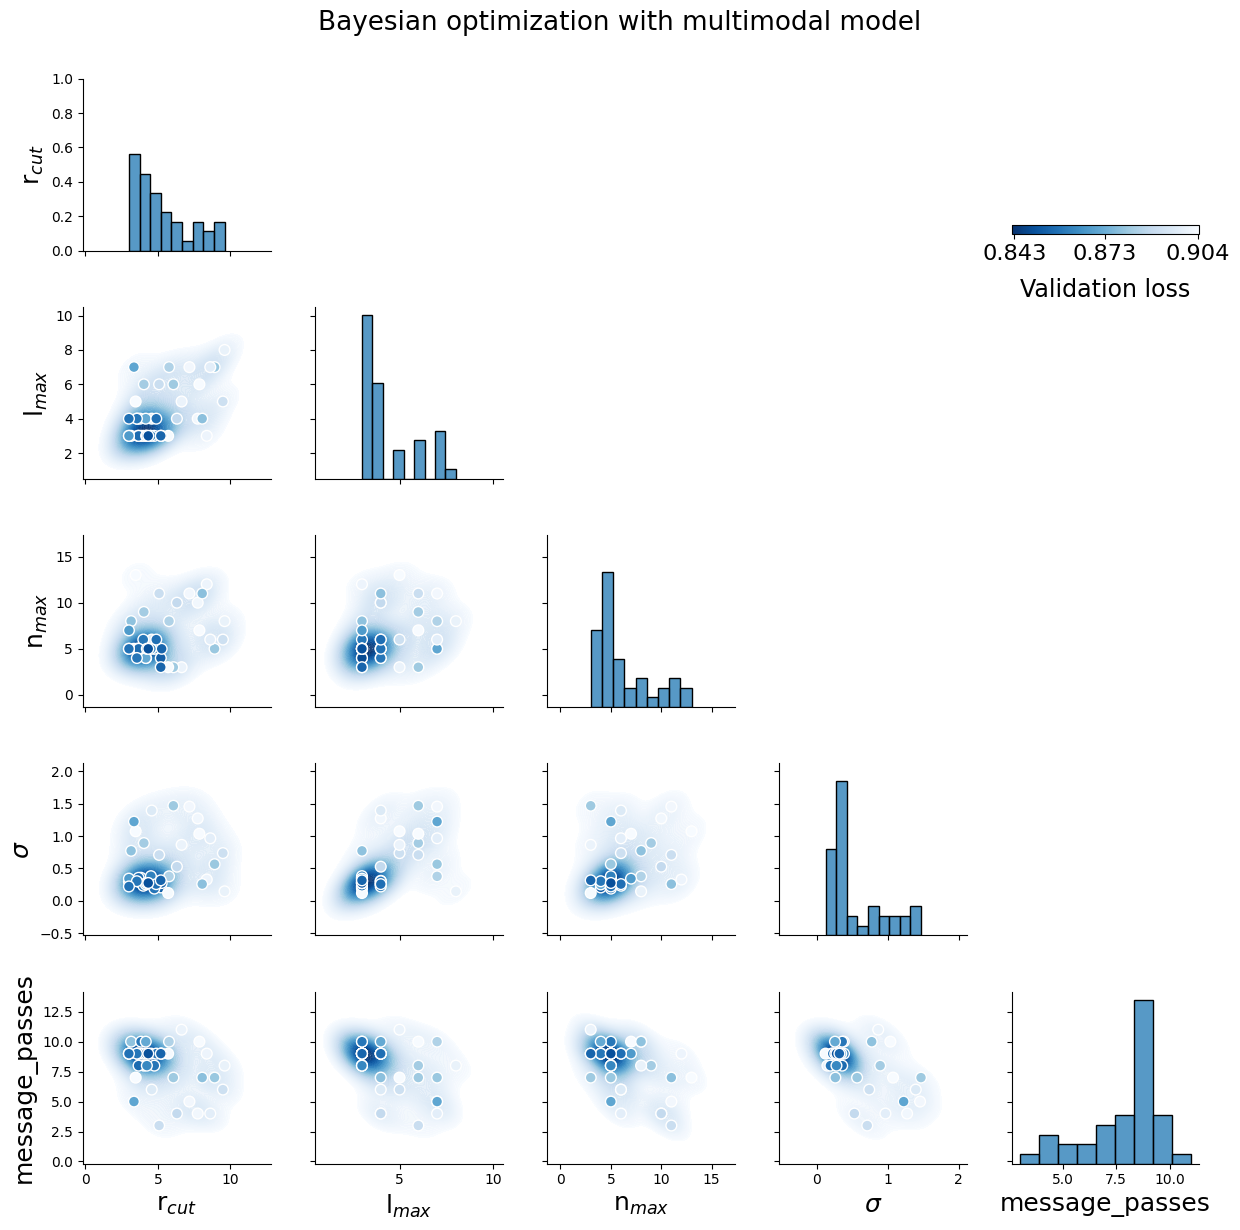

In [10]:
title = "Bayesian optimization with multimodal model"
plot_bayesopt_results(results_df[param_names], "Blues_r",
                      results_df["validation_loss"].values,
                      labels, title=title,
                      loss="Validation loss",
                      savefile="bayesopt_{}.png".format(modname),
                      alpha=1.0)

### Test predictions

In [11]:
TestGraphs = [MoleculeGraph(names[i],
                            SMILES[i],
                            y[i],
                            i,
                            desc_names=desc_names,
                            feature_sets=feature_sets,
                            structure_format="xyz",
                            soap_parameters={"r_cut": best_params[0], 
                                             "l_max": int(best_params[1]),
                                             "n_max": int(best_params[2]),
                                             "atom_sigma": best_params[3],
                                             "compression_mode": compression_mode, 
                                             "species": species,}) for i in range(n_train, data.shape[0])]


test_dataset = []
for mg in TestGraphs:
    x=mg.node_features
    edge_features=mg.edge_features
    datapoint=Data(x=torch.tensor(x,dtype=torch.float),
                   y=torch.tensor(mg.y, dtype=torch.float),
                   name=mg.name,
                   edge_index=mg.edge_list,
                   edge_attr=torch.tensor(edge_features, dtype=torch.float),
                   num_nodes=x.shape[0],
                   index=mg.index)
    if mg.molecule_features is not None:
        mol_features=np.hstack(mg.molecule_features)
        datapoint.__setattr__("molecule_features",
                              torch.tensor(mol_features.reshape(1,-1),dtype=torch.float))
    test_dataset.append(datapoint)
    
    
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         worker_init_fn=seed_worker,
                         generator=g,
                         shuffle=False,)

In [12]:
# Reset number of units in linear layers for node, edge input 
node_units[0] = TestGraphs[0].node_features.shape[1]
edge_units[0] = TestGraphs[0].edge_features.shape[1]

test_results = {}

yh_ensemble = np.zeros(len(y_test))
test_scores = np.zeros((6,5))

for k in range(5):
    model = GraphNet(node_units,
                     edge_units,
                     molecule_units,
                     fcnn_units,
                     int(torch.round(best_params[-1])),
                     dropout=[0.50,0.50])

    model.load_state_dict(model_state["states"][f"fold{k}"])

    # Make predictions
    yh_test = predict(model, test_loader)
    test_scores[k] = compute_metrics(yh_test, y_test.ravel())

    test_results[f"fold{k}"] = {"y_hat": yh_test,
                                "scores": test_scores[k],}
    
    yh_ensemble += yh_test*0.20

test_scores[-1] = compute_metrics(yh_ensemble, y_test.ravel())
test_results["ensemble"] = {"y_hat": yh_ensemble,
                            "scores": test_scores[-1]}

print_score_summary(test_scores[-1])

# with open('{}_test_results.pkl'.format(modname),'wb') as handle:
#     pkl.dump(test_results, handle, protocol=pkl.HIGHEST_PROTOCOL)

Root Mean Squared Error:                 0.96300
Mean Absolute Error:                     0.66909
Pearson Correlation Coefficient (r):     0.91062
Coefficient of Determination (R2):       0.82401
% within 0.50 of experimental:           0.53017


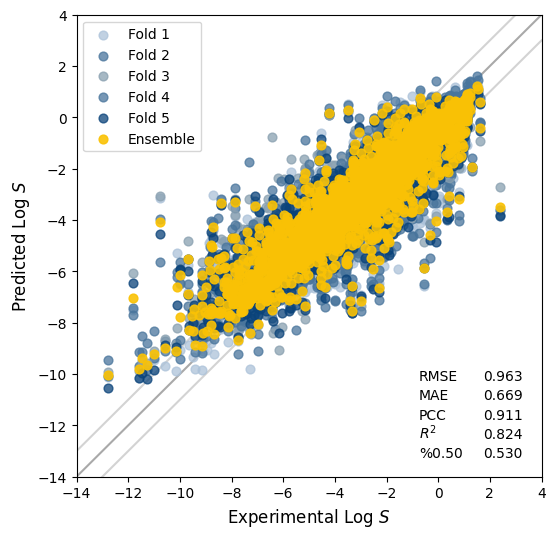

In [13]:
plt.figure(figsize=(6,6))
for k in range(5):
    yh_test = test_results[f"fold{k}"]["y_hat"]
    plt.scatter(y_test,yh_test,alpha=0.75,s=40,
                color=ytest_colors[k],label=f"Fold {k+1}")
plt.scatter(y_test,test_results["ensemble"]["y_hat"],alpha=0.9,s=40,
            color="#fac205",label="Ensemble") 
plot_scores(test_scores[-1], x0=-2.5, fontsize=10)
format_scatter_plot(lb,ub,
                    axis_labels=axis_labels,
                    legend_size = 10,
                    fontsize=fontsize)

plt.savefig(f"ensemble_{modname}.png", dpi=300)
plt.show()